In [1]:
from finlab_crypto import crawler

In [21]:
BTC=crawler.get_all_binance(symbol="BTCUSDT",kline_size='1h')

All caught up..!


In [23]:
BTC=BTC[['open', 'high', 'low', 'close','volume']]

In [24]:
# 選取相關欄位並處理缺失值

# 計算價格變動百分比作為目標變量
BTC['Price_Change'] = BTC['close'].pct_change()
BTC.dropna(inplace=True)
btc=BTC


C:\Users\雙肩股份有限公司\AppData\Local\Temp\ipykernel_34692\836088372.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTC['Price_Change'] = BTC['close'].pct_change()
C:\Users\雙肩股份有限公司\AppData\Local\Temp\ipykernel_34692\836088372.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTC.dropna(inplace=True)


In [26]:
from sklearn.preprocessing import MinMaxScaler

# 將數據分為訓練集與測試集
train_data = btc.iloc[:int(0.8*len(btc))]
test_data = btc.iloc[int(0.8*len(btc)):]

# 正規化
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)


In [27]:
import numpy as np
import xgboost as xgb

# 將訓練集和測試集的特徵和目標分開
X_train = train_scaled[:, :-1]  # 使用所有列（除了最後一列）作為特徵
y_train = train_scaled[:, -1]   # 最後一列（close）作為目標
X_test = test_scaled[:, :-1]
y_test = test_scaled[:, -1]


In [28]:

# 定義 XGBoost 迴歸模型
xgboost_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=15,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

# 訓練模型
xgboost_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [29]:
# 使用測試集進行預測
y_pred = xgboost_model.predict(X_test)


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 計算均方根誤差（RMSE）
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# 計算平均絕對誤差（MAE）
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)


RMSE: 0.011947751973963217
MAE: 0.0076566532610836385


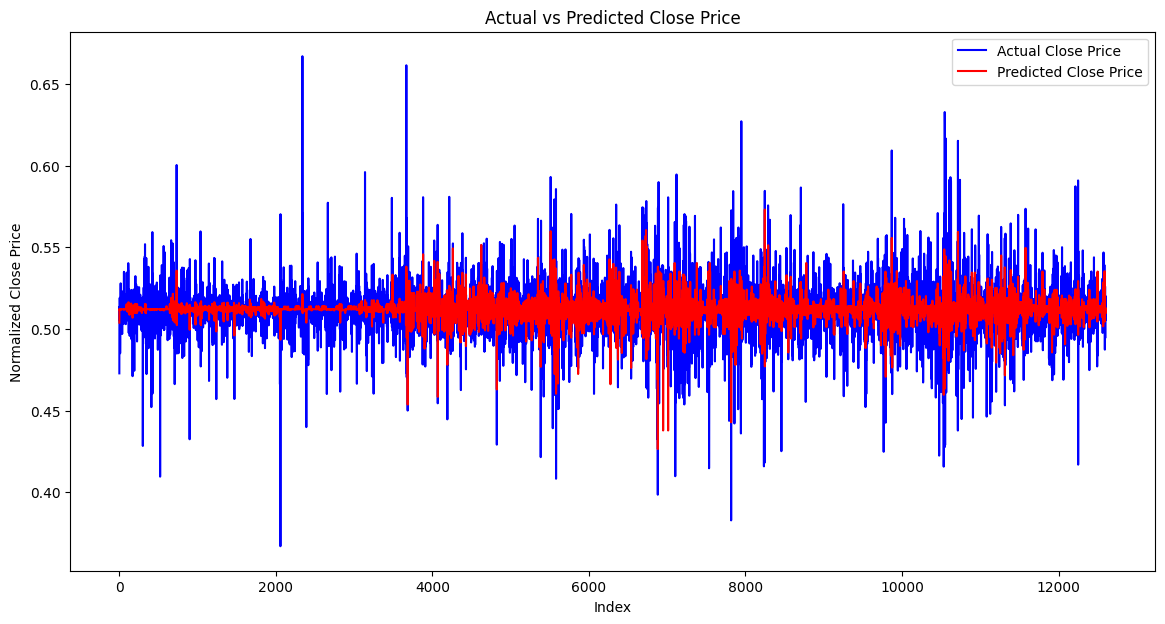

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Close Price', color='blue')
plt.plot(y_pred, label='Predicted Close Price', color='red')
plt.xlabel('Index')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.title('Actual vs Predicted Close Price')
plt.show()


In [45]:
import numpy as np

# 設定閾值
buy_threshold = 0.01  # 預測漲幅大於 1% 時買入
sell_threshold = -0.01  # 預測跌幅超過 -1% 時賣出

# 模擬交易
def generate_trading_signals(predictions):
    signals = []
    for pred in predictions:
        if pred > buy_threshold:
            signals.append("Buy")
        elif pred < sell_threshold:
            signals.append("Sell")
        else:
            signals.append("Hold")
    return signals

# 生成交易信號
signals = generate_trading_signals(y_pred)


NameError: name 'actual_prices' is not defined

In [56]:
def backtest_trading_strategy(signals, actual_prices):
    balance = 10000  # 初始資金
    position = 0  # 初始持倉
    entry_price = 0
    
    
    for i, signal in enumerate(signals):
        if signal == "Buy" and position == 0:
            # 買入操作
            entry_price = actual_prices[i]
            position = balance / entry_price
            balance = 0
            print(f"Buy at {entry_price}")
        
        elif signal == "Sell" and position > 0:
            # 賣出操作
            balance = position * actual_prices[i]
            position = 0
            print(f"Sell at {actual_prices[i]}")
    
    # 結束時的餘額
    final_balance = balance + position * actual_prices[-1]
    print(f"Final balance: {final_balance}")
    
    return final_balance

# 執行回測
final_balance = backtest_trading_strategy(signals, test_close_scaled)
print("Backtest Final Balance:", final_balance)



Buy at [0.36319124]
Final balance: [29088.900993]
Backtest Final Balance: [29088.900993]


In [57]:
# 1. 單獨正規化 close 欄位
close_scaler = MinMaxScaler()
train_close_scaled = close_scaler.fit_transform(train_data[['close']])
test_close_scaled = close_scaler.transform(test_data[['close']])

# 2. 為其他欄位創建 scaler 進行正規化
other_features_scaler = MinMaxScaler()
train_other_scaled = other_features_scaler.fit_transform(train_data.drop(columns=['close']))
test_other_scaled = other_features_scaler.transform(test_data.drop(columns=['close']))

# 3. 將反正規化應用於 close 值
y_test_original = close_scaler.inverse_transform(y_test_reshaped).flatten()

# 4. 使用反正規化的 close 值進行回測
final_balance = backtest_trading_strategy(signals, y_test_original)
print("Backtest Final Balance:", final_balance)


Buy at 33986.17925652716
Final balance: 10637.202248744954
Backtest Final Balance: 10637.202248744954
